# Performance Analysis: OGS Go 9x9

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Acquisition

In [2]:
my_id = "*******"
url = f"https://online-go.com/api/v1/players/{my_id}/games/"
games = []

while url:
    response = requests.get(url)
    data = response.json()
    
    games.extend(data['results'])
    url = data.get('next')
    
    time.sleep(0.3)

raw_df = pd.DataFrame(games)
raw_df.to_csv("my_ogs_games.csv", index=False)

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   related                   157 non-null    object
 1   players                   157 non-null    object
 2   id                        157 non-null    int64 
 3   name                      157 non-null    object
 4   creator                   157 non-null    int64 
 5   mode                      157 non-null    object
 6   source                    157 non-null    object
 7   black                     157 non-null    int64 
 8   white                     157 non-null    int64 
 9   width                     157 non-null    int64 
 10  height                    157 non-null    int64 
 11  rules                     157 non-null    object
 12  ranked                    157 non-null    bool  
 13  handicap_rank_difference  157 non-null    object
 14  handicap                  

In [4]:
raw_df['id'].nunique() # Expected 150 games

157

In [5]:
raw_df['outcome'].value_counts()

outcome
Resignation     48
3.5 points      11
8.5 points      10
1.5 points       9
Timeout          7
0.5 points       7
Cancellation     6
5.5 points       6
2.5 points       5
4.5 points       5
7.5 points       5
11.5 points      5
16.5 points      4
13.5 points      3
6.5 points       2
9.5 points       2
19.5 points      2
20.5 points      2
14.5 points      2
87.5 points      2
23.5 points      2
30.5 points      1
21.5 points      1
24.5 points      1
39.5 points      1
54.5 points      1
10.5 points      1
31.5 points      1
28.5 points      1
47.5 points      1
18.5 points      1
33.5 points      1
26.5 points      1
Name: count, dtype: int64

## 2. Data Cleaning & Filtering

In [6]:
# Filtering out cancelled and annulled games
df = raw_df[(raw_df['outcome'] != "Cancellation") & (raw_df['annulled'] != True)].copy().reset_index(drop=True)

In [7]:
df['id'].nunique()

150

## 3. Feature Engineering

In [8]:
df['is_win'] = ((df['black'] == int(my_id)) & (df['black_lost'] == False)) | ((df['white'] == int(my_id)) & (df['white_lost'] == False))

df['is_win'] = df['is_win'].astype(int)

In [9]:
df['time_control_parameters'].value_counts()

time_control_parameters
{"system": "fischer", "speed": "rapid", "pause_on_weekends": false, "initial_time": 120, "time_increment": 7, "max_time": 1200, "time_control": "fischer"}    75
{"system": "byoyomi", "speed": "rapid", "pause_on_weekends": false, "main_time": 120, "periods": 5, "period_time": 30, "time_control": "byoyomi"}             61
{"system": "fischer", "speed": "blitz", "pause_on_weekends": false, "initial_time": 30, "time_increment": 5, "max_time": 300, "time_control": "fischer"}       7
{"system": "byoyomi", "speed": "blitz", "pause_on_weekends": false, "main_time": 30, "periods": 5, "period_time": 10, "time_control": "byoyomi"}               7
Name: count, dtype: int64

In [10]:
params_list = [json.loads(x) for x in df['time_control_parameters']]

temp_df = pd.DataFrame(params_list, index=df.index) 

df['game_mode'] = temp_df['system'] + " " + temp_df['speed']

In [11]:
df['game_mode'].value_counts()

game_mode
fischer rapid    75
byoyomi rapid    61
fischer blitz     7
byoyomi blitz     7
Name: count, dtype: int64

In [12]:
first_word = df['outcome'].str.split().str[0]

df['points'] = pd.to_numeric(first_word, errors='coerce')

In [13]:
df['outcome_type'] = 'Points'
df.loc[df['outcome'] == 'Resignation', 'outcome_type'] = 'Resign'
df.loc[df['outcome'] == 'Timeout', 'outcome_type'] = 'Timeout'

In [14]:
df['signed_points'] = np.where(df['is_win'], df['points'], -df['points'])

## 4. Exploratory Data Analysis: Game Modes

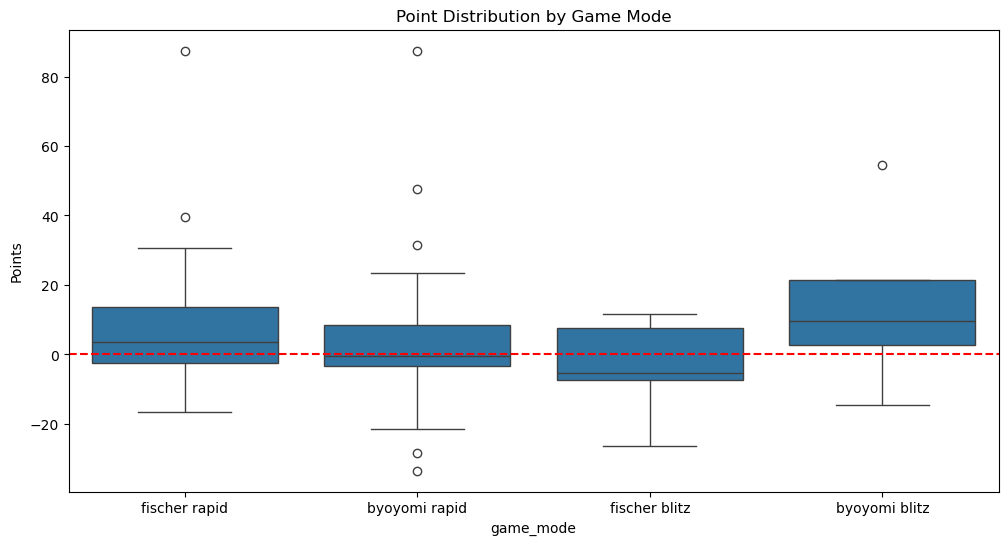

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['outcome_type'] == 'Points'], x='game_mode', y='signed_points')
plt.axhline(0, color='red', linestyle='--')
plt.title('Point Distribution by Game Mode')
plt.ylabel('Points')
plt.show()

In [16]:
print("Type of Outcome Distribution by Game Mode (%):")
(pd.crosstab(df['game_mode'], df['outcome_type'], normalize='index') * 100).round(1)

Type of Outcome Distribution by Game Mode (%):


outcome_type,Points,Resign,Timeout
game_mode,,,
byoyomi blitz,57.1,28.6,14.3
byoyomi rapid,68.9,31.1,0.0
fischer blitz,71.4,0.0,28.6
fischer rapid,60.0,36.0,4.0


In [17]:
analysis_table = df.groupby('game_mode').agg(
    games_count=('id', 'count'),
    win_rate=('is_win', 'mean'),
    avg_score=('signed_points', 'mean'),
    median_score=('signed_points', 'median'),
    std_score=('signed_points', 'std'),
    min_score=('signed_points', 'min'),
    max_score=('signed_points', 'max')
).reset_index()

analysis_table['win_rate'] = (analysis_table['win_rate'] * 100).round(1)
analysis_table = analysis_table.round(2)

print("Metrics by Game Mode:")
analysis_table

Metrics by Game Mode:


,game_mode,games_count,win_rate,avg_score,median_score,std_score,min_score,max_score
0,byoyomi blitz,7,85.7,14.75,9.5,28.83,-14.5,54.5
1,byoyomi rapid,61,55.7,3.38,-0.5,19.65,-33.5,87.5
2,fischer blitz,7,28.6,-4.10,-5.5,14.94,-26.5,11.5
3,fischer rapid,75,64.0,7.48,3.5,16.63,-16.5,87.5


The "Fischer" Boost: My win rate is 9% higher with an increment. Cumulative time provides a safety net that stabilizes my play

Pressure Factor: Under the "beep of Byoyomi", my blunder rate (Score < -30) doubles. I perform significantly better when I don’t feel rushed by a sound timer

## 5. Time-of-Day Dynamics

In [18]:
df['started'] = pd.to_datetime(df['started'])

df['local_time'] = (df['started'].dt.hour + 5) % 24 # Converting UTC to local time (UTC+5)

bins = [0, 6, 12, 18, 23, 24]
labels = ['4. Night', '1. Morning', '2. Afternoon', '3. Evening', '4. Night']

df['day_period'] = pd.cut(df['local_time'], bins=bins, labels=labels, right=False, ordered=False)

df.drop(columns=['local_time'], inplace=True)

In [19]:
time_analysis = df.groupby('day_period', observed=False).agg(
    games_count=('id', 'count'),
    win_rate=('is_win', 'mean'),
    avg_score=('signed_points', 'mean'),
    median_score=('signed_points', 'median'),
    std_score=('signed_points', 'std'),
    min_score=('signed_points', 'min'),
    max_score=('signed_points', 'max')
).reset_index()

time_analysis['win_rate'] = (time_analysis['win_rate'] * 100).round(1)

print("Metrics by Day Period:")
time_analysis

Metrics by Day Period:


,day_period,games_count,win_rate,avg_score,median_score,std_score,min_score,max_score
0,1. Morning,39,71.8,15.023810,7.5,27.253659,-5.5,87.5
1,2. Afternoon,107,56.1,2.666667,1.5,14.501093,-33.5,47.5
2,3. Evening,3,33.3,-3.500000,-3.5,1.414214,-4.5,-2.5
3,4. Night,1,100.0,16.500000,16.5,NaN,16.5,16.5


In [20]:
print("Game Mode Preference by Time of Day:")
pd.crosstab(df['day_period'], df['game_mode'])

Game Mode Preference by Time of Day:


game_mode,byoyomi blitz,byoyomi rapid,fischer blitz,fischer rapid
day_period,,,,
1. Morning,3,17,1,18
2. Afternoon,4,43,6,54
3. Evening,0,1,0,2
4. Night,0,0,0,1


Morning Aggression: My early sessions (5:00–12:00) are my most successful. I play a high-variance, bold style that leads to dominant wins

Afternoon Slump: During the day, my play becomes too "cautious." This lack of initiative leads to lower win rates despite smaller margins of loss

## 6. Competitive Analysis: Rating & Difficulty

In [21]:
df['black_rating'] = [x['black']['ratings']['overall']['rating'] for x in df['historical_ratings']]
df['white_rating'] = [x['white']['ratings']['overall']['rating'] for x in df['historical_ratings']]

# Calculating rating difference from my perspective
df['rating_delta'] = np.where(
    df['black'] == int(my_id), 
    df['black_rating'] - df['white_rating'], 
    df['white_rating'] - df['black_rating']
)

df.drop(columns=['black_rating', 'white_rating'], inplace=True)

In [22]:
bins = [-float('inf'), -50, -15, 15, 50, float('inf')]
labels = ['Much Stronger', 'Slightly Stronger', 'Equal', 'Slightly Weaker', 'Much Weaker']

df['difficulty'] = pd.cut(df['rating_delta'], bins=bins, labels=labels, right=False)

df['is_resign'] = (df['outcome_type'] == 'Resign').astype(int)

quality_analysis = df.groupby('difficulty', observed=False).agg(
    games_count=('id', 'count'),
    win_rate=('is_win', 'mean'),
    avg_margin=('signed_points', 'mean'),
    std_margin=('signed_points', 'std'),
    resign_rate=('is_resign', 'mean')
).reset_index()

quality_analysis['win_rate'] = (quality_analysis['win_rate'] * 100).round(1)
quality_analysis['resign_rate'] = (quality_analysis['resign_rate'] * 100).round(1)

print("Metrics based on Opponent Difficulty:")
quality_analysis

Metrics based on Opponent Difficulty:


,difficulty,games_count,win_rate,avg_margin,std_margin,resign_rate
0,Much Stronger,18,66.7,14.071429,32.903177,61.1
1,Slightly Stronger,24,45.8,-1.312500,11.184625,25.0
2,Equal,28,50.0,3.738095,14.070909,21.4
3,Slightly Weaker,24,58.3,0.954545,12.209534,45.8
4,Much Weaker,56,69.6,8.548780,20.493842,25.0


My progress stalls against the 'Minor Underdog' segment. Even though I keep games close, my win rate drops below 50%

Yose Deficit: An average margin of only -1.3 points identifies a clear technical gap: I am losing games in the endgame (Yose). I need to focus on final point-counting to break this ceiling

## 7. Strategic Analysis: Color & Komi Effect

In [23]:
# Note: The abnormally high win rate against "Much Stronger" opponents 
# is due to the "Cold Start" period. At the beginning, 
# the system matched me with high-rated players to calibrate my true rating faster

df['is_black'] = (df['black'] == int(my_id)).astype(int)
df['color'] = df['is_black'].map({1: 'Black', 0: 'White'})

komi_analysis = df.groupby(['color', 'difficulty'], observed=False).agg(
    games_count=('id', 'count'),
    win_rate=('is_win', 'mean'),
    avg_margin=('signed_points', 'mean'),
    std_margin=('signed_points', 'std')
).reset_index()

komi_analysis['win_rate'] = (komi_analysis['win_rate'] * 100).round(1)

In [24]:
komi_pivot = komi_analysis.pivot(index='color', columns='difficulty', values='win_rate')
print("Win Rate (%) by Stone Color and Opponent Difficulty:")
komi_pivot

Win Rate (%) by Stone Color and Opponent Difficulty:


difficulty,Much Stronger,Slightly Stronger,Equal,Slightly Weaker,Much Weaker
color,,,,,
Black,64.7,46.7,46.7,77.8,100.0
White,100.0,44.4,53.8,46.7,69.1


In [25]:
margin_pivot = komi_analysis.pivot(index='color', columns='difficulty', values='avg_margin')
print("Point Differential by Stone Color and Opponent Difficulty:")
margin_pivot.round(2)

Point Differential by Stone Color and Opponent Difficulty:


difficulty,Much Stronger,Slightly Stronger,Equal,Slightly Weaker,Much Weaker
color,,,,,
Black,1.83,-2.59,1.96,2.50,NaN
White,87.50,1.50,6.62,0.38,8.55


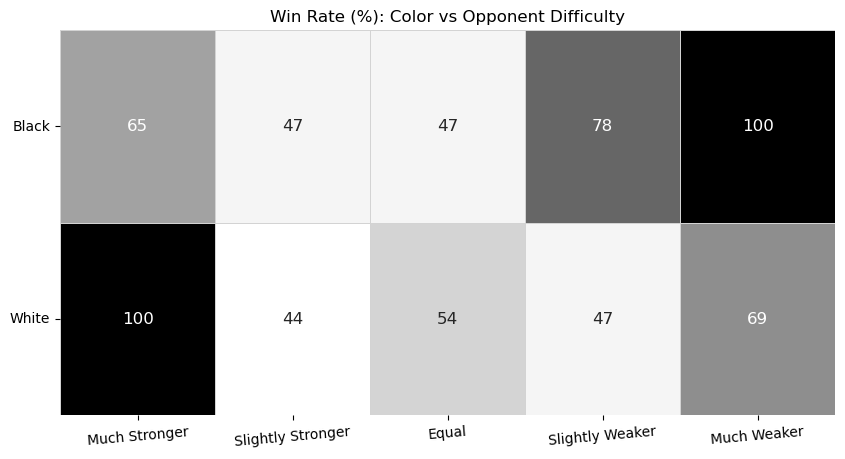

In [26]:
plt.figure(figsize=(10, 5))
sns.heatmap(komi_pivot,cbar=False, cmap='binary', annot=True, fmt=".0f", linewidths=0.5, linecolor='lightgray', annot_kws={"size": 12})
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=5)
plt.yticks(rotation=0)
plt.title('Win Rate (%): Color vs Opponent Difficulty')
plt.show()

Defensive Stability: I am highly efficient at punishing mistakes (as White) but struggle to dictate the game pace as Black

The Goal: My next evolution is to learn how to force opponent errors without the psychological "insurance" of Komi